In [1]:
%matplotlib widget
import sympy as sp
from scipy.optimize import root
import numpy as np
import matplotlib.pyplot as plt
from bmcs_beam.api import SLSParamStudy, BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign, BeamSLSCurve, LoadDeflectionParamsStudy
from bmcs_cross_section.api import EC2, EC2CreepShrinkage

In [6]:
# x = sp.Symbol('x', positive=True)
# n_val = EC2.get_n(30)
# sig_c_val = sig_c.subs({eps_c2: 2, eps_cu2: 3.5, n: n_val})
# sig_c_val
# alpha_R = sp.integrate(sig_c_val, (eps_c, 0, 3.5)) / (x * f_cd)
# alpha_R

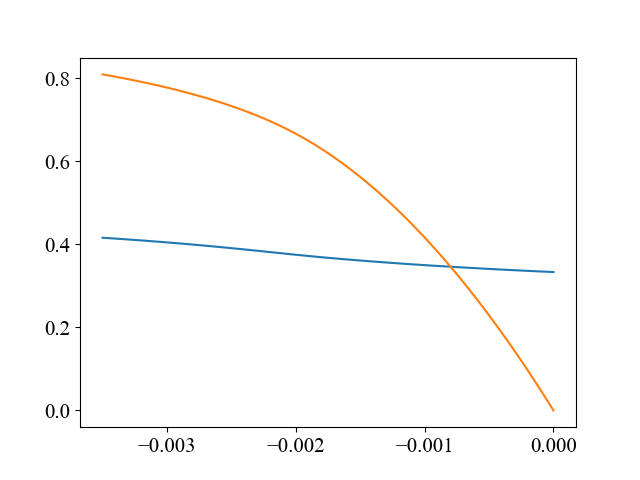

In [22]:
eps_c2, eps_cu2, n, rho, eps_c, E_f, eps_f, k_a, sig_f, A_f, d, b, f_cd = sp.symbols('varepsilon_c2, varepsilon_cu2, n, rho, varepsilon_c, E_f, varepsilon_f, k_a, sig_f, A_f, d, b, f_cd')

# sig_c = sp.Piecewise(
#      (f_cd * (1 - (1 - eps_c / eps_c2)**n), eps_c <= eps_c2),
#      (f_cd, eps_c <= eps_cu2),
# )

alpha_R = sp.Piecewise(
        (-(eps_c*1000)/2 - (eps_c*1000)**2/12, eps_c >= -0.002),
        (1 + 2/(3*(eps_c*1000)), eps_c >= -0.0035),
        (np.nan, True)
)

k_a = sp.Piecewise(
     ((8 + (eps_c*1000)) / (24 + 4 * (eps_c*1000)), eps_c >= -0.002),
     ((3 * (eps_c*1000)**2 + 4 * (eps_c*1000) + 2) / (6 * (eps_c*1000)**2 + 4 * (eps_c*1000)), eps_c >= -0.0035),
    (np.nan, True)
)


eps_c_list = np.linspace(0, -0.0035, 50)
alpha_R_list = []
k_a_list = []

for eps_c_val in eps_c_list:
    alpha_R_list.append(alpha_R.subs(eps_c, eps_c_val))
    k_a_list.append(k_a.subs(eps_c, eps_c_val))

fig, ax = plt.subplots()
ax.plot(eps_c_list, k_a_list)
ax.plot(eps_c_list, alpha_R_list)

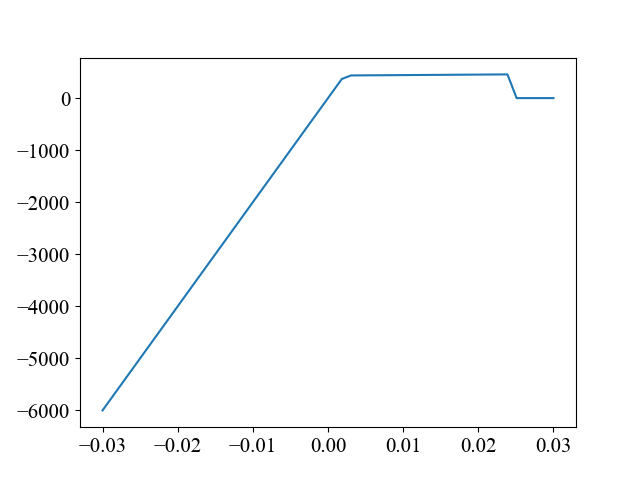

In [68]:
eps_c2, eps_cu2, n, rho, eps_c, E_f, eps_f, k_a, sig_f, A_f, d, b, f_cd = sp.symbols('varepsilon_c2, varepsilon_cu2, n, rho, varepsilon_c, E_f, varepsilon_f, k_a, sig_f, A_f, d, b, f_cd')
f_sy = 500

f_syd = f_sy/1.15
f_std = 1.05 * f_syd
eps_ud = 0.025
eps_syd = f_syd / E_f
sig_f = sp.Piecewise(
    (E_f * eps_f, eps_f < eps_syd),
    (f_syd + (f_std - f_syd) * ((eps_f - eps_syd) / (eps_ud - eps_syd)), eps_f < eps_ud),
    (0, True),
)

sig_f
eps_c_list = np.linspace(-0.03, 0.03, 50)
sig_f_list = []

for eps_f_val in eps_c_list:
    sig_f_list.append(sig_f.subs({eps_f: eps_f_val, E_f:200000}))

fig, ax = plt.subplots()
ax.plot(eps_c_list, sig_f_list)

In [86]:
def get_m_Ed(rho_val = 0.002, f_ck=30, eps_fu=0.01, reinf = 'carbon', f_sy = 500, 
             E_f_value=100000, b_value=1000, d_value=270):
    eps_c2, eps_cu2, n, rho, eps_c, E_f, eps_f, k_a, sig_f, A_f, d, b, f_cd = sp.symbols('varepsilon_c2, varepsilon_cu2, n, rho, varepsilon_c, E_f, varepsilon_f, k_a, sig_f, A_f, d, b, f_cd')

    # sig_c = sp.Piecewise(
    #      (f_cd * (1 - (1 - eps_c / eps_c2)**n), eps_c <= eps_c2),
    #      (f_cd, eps_c <= eps_cu2),
    # )

    alpha_R = sp.Piecewise(
            (-(eps_c*1000)/2 - (eps_c*1000)**2/12, eps_c >= -0.002),
            (1 + 2/(3*(eps_c*1000)), eps_c >= -0.0035),
            (np.nan, True)
    )

    k_a = sp.Piecewise(
         ((8 + (eps_c*1000)) / (24 + 4 * (eps_c*1000)), eps_c >= -0.002),
         ((3 * (eps_c*1000)**2 + 4 * (eps_c*1000) + 2) / (6 * (eps_c*1000)**2 + 4 * (eps_c*1000)), eps_c >= -0.0035),
        (np.nan, True)
    )


    zeta = -eps_c / (-eps_c + eps_f)
    x = d * zeta
    F_cd = alpha_R * x * b * f_cd
    z = d * (1 - k_a * zeta)
    M_Ed = F_cd * z

    mu_Ed = M_Ed / (b * d**2 * f_cd)

    A_f = rho * b * d
    
    if reinf == 'steel':
        f_syd = f_sy/1.15
        f_std = 1.05 * f_syd
        eps_ud = 0.025
        eps_syd = f_syd / E_f
#         sig_f = sp.Piecewise(
#             (E_f * eps_f, eps_f < eps_syd),
#             (f_syd + (f_std - f_syd) * ((eps_f - eps_syd) / (eps_ud - eps_syd)), eps_f < eps_ud),
#             (0, True),
#         )
        
#         sig_f = sp.Min(E_f * eps_f, f_syd)
    
        sig_f = sp.Piecewise(
            (E_f * eps_f, eps_f < eps_syd),
            (f_syd, True),
        )
    else:
        sig_f = E_f * eps_f
    
    F_f = A_f * sig_f

    eps_cu = -EC2.get_eps_cu2(f_ck)
    # TODO: f_cd must be negative or positive in the following?!
    data = {E_f: E_f_value, f_cd: EC2.get_f_cd(f_ck), b : b_value, d : d_value}

    eq = (F_f - F_cd).subs(data)
    
    if reinf == 'steel':
        eps_f_sol = sp.solve(eq.subs({eps_c: eps_cu, rho: rho_val}), eps_f)
#         print('eps_f_sol =', eps_f_sol)
        eps_f_sol = np.max(np.array(eps_f_sol))

        mu_Ed_val = mu_Ed.subs(data).subs({eps_c: eps_cu, rho: rho_val, eps_f: eps_f_sol})

        print('zeta = x/d =', zeta.subs({eps_c: eps_cu, eps_f: eps_f_sol}))
        return mu_Ed_val
    
    rho_bal = sp.solve(eq.subs({eps_c: eps_cu, eps_f: eps_fu}), rho)[0]
    mu_Ed_bal = mu_Ed.subs(data).subs({eps_c: eps_cu, eps_f: eps_fu})
    
#     print('rho_bal =', rho_bal)
#     print('mu_Ed_bal =', mu_Ed_bal)

    if rho_val < rho_bal:
        eq_subs = eq.subs({eps_f: eps_fu, rho: rho_val})
        eq_lambd = sp.lambdify((eps_c), eq_subs, 'numpy')
        eps_c_sol = root(lambda eps_c: eq_lambd(eps_c), -0.0000001, tol=1e-6)
        
        if not eps_c_sol.success:
            print('No solution', eps_c_sol.message)
        else:
            eps_c_sol = eps_c_sol.x[0]
            print('eps_c_sol =', eps_c_sol)

        mu_Ed_val = mu_Ed.subs(data).subs({eps_f: eps_fu, rho: rho_val, eps_c: eps_c_sol})
#         M_Ed_val = M_Ed.subs(data).subs({eps_f: eps_fu, rho: rho_val, eps_c: eps_c_sol})/1e6
#         print('mu_Ed_val =', mu_Ed_val)
#         print('M_Ed_val =', M_Ed_val)

    elif rho_val > rho_bal:
        eps_f_sol = sp.solve(eq.subs({eps_c: eps_cu, rho: rho_val}), eps_f)
#         print('eps_f_sol =', eps_f_sol)
        eps_f_sol = np.max(np.array(eps_f_sol))

        mu_Ed_val = mu_Ed.subs(data).subs({eps_c: eps_cu, rho: rho_val, eps_f: eps_f_sol})
    #     M_Ed_val = M_Ed.subs(data).subs({eps_c: eps_cu, rho: rho_val, eps_f: eps_f_sol})/1e6
    #     print('mu_Ed_val =', mu_Ed_val)
    #     print('M_Ed_val =', M_Ed_val)

    else:
        mu_Ed_val = mu_Ed_bal

    return mu_Ed_val
get_m_Ed(0.01, reinf='steel')

zeta = x/d = 0.315931999398225


0.222143966192671

In [10]:
def get_k_xI(rho_s1, rho_s2, d, d_2, h, E_s, E_cm_eff):
    # rho_s2: is compression reinf. ratio
    alpha_e = E_s/E_cm_eff
    # TODO: check B_I
    B_I = (alpha_e - 1) * (rho_s1 + rho_s2)
    A_I = (B_I / h) * (d + d_2)
    return (0.5 + A_I) / (1 + B_I)

def get_k_I(rho_s1, rho_s2, d, d_2, h, E_s, E_cm_eff):
    alpha_e = E_s/E_cm_eff
    k_xI = get_k_xI(rho_s1, rho_s2, d, d_2, h, E_s, E_cm_eff)
    tmp1 = 12 * (0.5 - k_xI) ** 2
    tmp2 = 12 * (alpha_e - 1) * rho_s1 * (d/h - k_xI) ** 2
    tmp3 = 12 * (alpha_e - 1) * rho_s1 * (rho_s2/rho_s1) * (k_xI - d_2/h) ** 2
    return 1 + tmp1 + tmp2 + tmp3

def get_k_xII(rho_s1, rho_s2, d, d_2, E_s, E_cm_eff):
    # rho_s2: is compression reinf. ratio
    # d_2: is the distance from top to compression reinf. (set to zero when no comp. reinf. available)
    alpha_e = E_s/E_cm_eff
    A_II = alpha_e * (rho_s1 + rho_s2)
    return - A_II + (A_II**2 + 2 * alpha_e * (rho_s1 + rho_s2 * d_2 / d))**0.5

def get_k_II(rho_s1, rho_s2, d, d_2, E_s, E_cm_eff):
    alpha_e = E_s/E_cm_eff
    k_xII = get_k_xII(rho_s1, rho_s2, d, d_2, E_s, E_cm_eff)
    tmp1 = 12 * alpha_e * rho_s1 * (1 - k_xII)**2
    tmp2 = 12 * alpha_e * rho_s1 * (rho_s2/rho_s1) * (k_xII - d_2/d)**2
    return 4 * k_xII ** 3 + tmp1 + tmp2

In [ ]:
# def get_mu_Ed(eps_c, eps_f):
#     if eps_c <= 2:
#         alpha_R = -eps_c/2 - eps_c**2/12
#         k_a = (8 + eps_c) / (24 + 4 * eps_c)
#     elif eps_c <= 3.5:
#         alpha_R = 1 + 2 / (3 * eps_c)
#         k_a = (3 * eps_c**2 + 4 * eps_c + 2) / (6 * eps_c ** 2 + 4 * eps_c)
#     else:
#         raise Exception('not valid eps_c!!')
    
#     xi  = eps_c / (eps_c + eps_f)
#     mu_Ed = alpha_R * xi * (1 - k_a * xi)
    
#     z = d * (1 - k_a * xi)
#     return mu_Ed, z

# def get_A_f_balanced(b, d, f_ck, eps_fu_d):
#     eps_cu2 = EC2.get_eps_cu2(f_ck)
#     f_cd = EC2.get_f_cd(f_ck)
#     mu_Ed, z = get_mu_Ed(eps_cu2 * 1000, eps_fu_d * 1000)
#     M_Ed = b * d**2 * f_cd * mu_Ed
#     A_f_balanced = M_Ed / (E_f * eps_fu_d * z)
#     return A_f_balanced

# E_f = 100000
# f_fu_d = 1000

# A_f_balanced = get_A_f_balanced(b, d, f_ck, E_f, f_fu_d)
# eps_fu_d = f_fu_d / E_f
# if A_f <= A_f_balanced:
#     mu_Ed, z = get_mu_Ed(3.5, eps_fu_d * 1000)
# else:
    

# eps_fu_d = f_fu_d / E_f
# mu_Ed, z = get_mu_Ed(3.5, eps_fu_d * 1000)
# M_Ed = (1000 * 270**2 * 30 * 0.85 / 1.5) * mu_Ed
# A_f_balanced = M_Ed / (E_f * eps_fu_d * z)
# mu_Ed, M_Ed/1e6, A_f_balanced, z

In [105]:
def get_w_elg(rho, L, f_ck = 30, b = 1000, mu_Ed = None, h = 300, 
              d= 270, E_r = 200000, reinf='steel', eps_fu = 0.01, sls_uls_ratio = 0.51, creep=True, shrinkage=True):
    eta = sls_uls_ratio
    
    f_ctm = EC2.get_f_ctm(f_ck)
    f_cd = EC2.get_f_cd(f_ck)
    A_c = b * h

    if mu_Ed is None:
        if reinf == 'steel':
            f_yk = 500
            mu_Ed = EC2.get_mu_Eds(rho, f_ck, f_yk)
#             print('mu_Ed1 =', mu_Ed)
#             mu_Ed = get_m_Ed(rho, f_ck, reinf = 'steel', E_f_value = 200000)
#             print('mu_Ed2 =', mu_Ed)
#             print('z, eps_f =', z, eps_f)
        else:
    #         f_uk = 2000 * 0.85
    #         mu_Ed = EC2.get_mu_Eds_FRP(rho, f_ck, f_uk)
            mu_Ed = get_m_Ed(rho, f_ck, eps_fu)
    #         print('mu_Ed =', mu_Ed)
    
    E_cm = EC2.get_E_cm(f_ck)
    RH = 70

    g_k = 0.36
    delta_g_k = 0.24
    q_k = 0.4
    psi_2 = 0.3
    u = 2 * b + 2 * h
    phi_inf_t_0  = EC2CreepShrinkage.get_creep_coefficient(f_ck, A_c, u, 10, RH=RH)
    phi_inf_t_1  = EC2CreepShrinkage.get_creep_coefficient(f_ck, A_c, u, 60, RH=RH)
    phi_inf_t_2  = EC2CreepShrinkage.get_creep_coefficient(f_ck, A_c, u, 365, RH=RH)
    phi_eq = (phi_inf_t_0 * g_k + phi_inf_t_1 * delta_g_k + phi_inf_t_2 * psi_2 * q_k) / (g_k + delta_g_k + psi_2 * q_k)
    
    if creep:
        E_c_eff = E_cm / (1 + phi_eq)
    else:
        E_c_eff = E_cm
        
    A_f = rho * b * d
    E_f = E_r
    omega_eff = (E_f / E_c_eff) * rho
    
#     omega_eff = mu_Ed * f_cd / (eps_f * z * E_c_eff / d)

    if shrinkage:
        eps_cs = EC2CreepShrinkage.get_eps_cs_shrinkage(f_ck, A_c, u, t_s=3, RH=RH)
    else:
        eps_cs = 0

    d_2 = 0
    k_xI = get_k_xI(rho, 0, d, d_2, h, E_f, E_c_eff)
    k_I =   get_k_I(rho, 0, d, d_2, h, E_f, E_c_eff)
    k_II = get_k_II(rho, 0, d, d_2, E_f, E_c_eff)

    zeta = 1- ((((h/d)**2) * (f_ctm/(6*E_c_eff)))/((eta * mu_Ed * f_cd / E_c_eff) + eps_cs * omega_eff * (1-k_xI * h/d)))**2
    xi_sls = omega_eff * ((1 + 2/omega_eff)**0.5 - 1)

    w_last = L * ((5/4) * (eta * mu_Ed * f_cd / E_c_eff) * (L/d) * (zeta/k_II + (1-zeta)/(k_I * (h/d)**3)))
    w_schwinden = L * ((5/4) * eps_cs * omega_eff * (L/d) * (zeta*(1-xi_sls)/k_II + (1-zeta) * (1- k_xI * h/d)/(k_I * (h/d)**3)))
    
    if shrinkage:
        return w_last
    else:
        return w_last + w_schwinden


In [111]:
f_ck = 30
b_sls = BeamSLSCurve(n_i=150)
d = 270

rho_range = b_sls.rho_range
slenderness_range = b_sls.slenderness_range
l_d_list = []
rho_list = []

for rho in rho_range:
    print('rho =', rho)
    
    eps_fu = 1650/230000
    mu_Ed = get_m_Ed(rho, f_ck, eps_fu)

#     mu_Ed = get_m_Ed(rho, f_ck, reinf = 'steel', E_f_value = 200000)

    for L_d in slenderness_range:
#         print('L_d =', L_d)
        L = L_d * d
#         w = get_w_elg(rho, L, mu_Ed= mu_Ed, f_ck = f_ck, d = d, E_r = 200000, reinf='steel')
#         w = get_w_elg(rho, L, f_ck = f_ck, d = d, E_r = 200000, reinf='steel')
#         w = get_w_elg(rho, L, f_ck = f_ck, d = d, E_r = 230000, reinf='carbon')
        w = get_w_elg(rho, L, eps_fu = eps_fu, mu_Ed = mu_Ed, f_ck = f_ck, d = d, E_r = 230000, reinf='carbon')
#         w = get_w_elg(rho, L, mu_Ed = mu_Ed, eps_fu = eps_fu, f_ck = f_ck, d = d, E_r = 100000, reinf='carbon', creep=False, shrinkage=False)
#         print('w =', w)
        if w >= L/250:
#             print('L/250 = ' , L/250)
#             print('w = ' , w)
            l_d_list.append(L_d)
            rho_list.append(rho)
            break
# rho_list, l_d_list, L/250

rho = 0.0002
eps_c_sol = -0.0003682884313093613
rho = 0.00036644295302013424
eps_c_sol = -0.0005095947830702339
rho = 0.0005328859060402685
eps_c_sol = -0.0006258130644828998
rho = 0.0006993288590604027
eps_c_sol = -0.0007286291995391104
rho = 0.0008657718120805369
eps_c_sol = -0.0008229306757923958
rho = 0.0010322147651006712
eps_c_sol = -0.0009113250340073784
rho = 0.0011986577181208056
eps_c_sol = -0.0009954061596283315
rho = 0.0013651006711409396
eps_c_sol = -0.001076239975628522
rho = 0.001531543624161074
eps_c_sol = -0.0011545877700742267
rho = 0.0016979865771812083
eps_c_sol = -0.0012310221762657672
rho = 0.0018644295302013424
eps_c_sol = -0.0013059930286811576
rho = 0.0020308724832214767
eps_c_sol = -0.0013798674782266793
rho = 0.002197315436241611
eps_c_sol = -0.0014529559177716006
rho = 0.0023637583892617453
eps_c_sol = -0.0015255296670346257
rho = 0.002530201342281879
eps_c_sol = -0.001597833702170488
rho = 0.0026966442953020135
eps_c_sol = -0.0016700963658038963
rho = 0.002

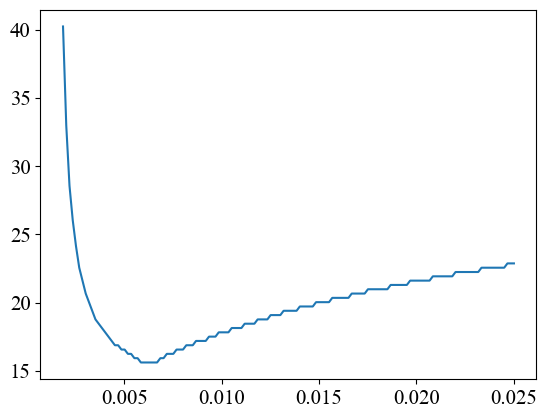

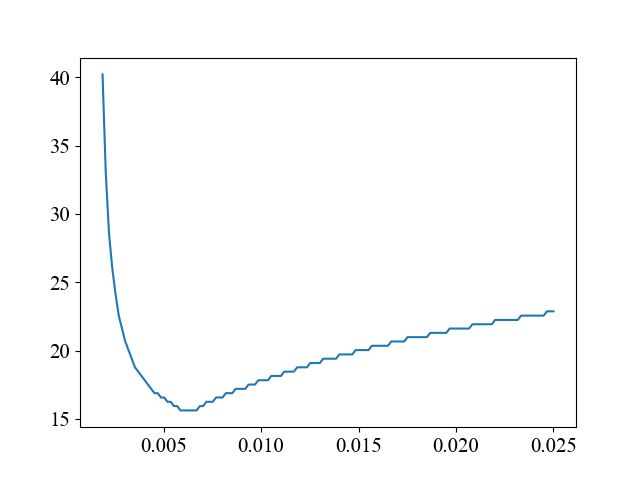

In [113]:
fig, ax = plt.subplots()
ax.plot(rho_list, l_d_list)
fig

In [104]:
fig.savefig('elg_calc_f_ck_30_curves_with_without_creep_shrinkage.pdf')

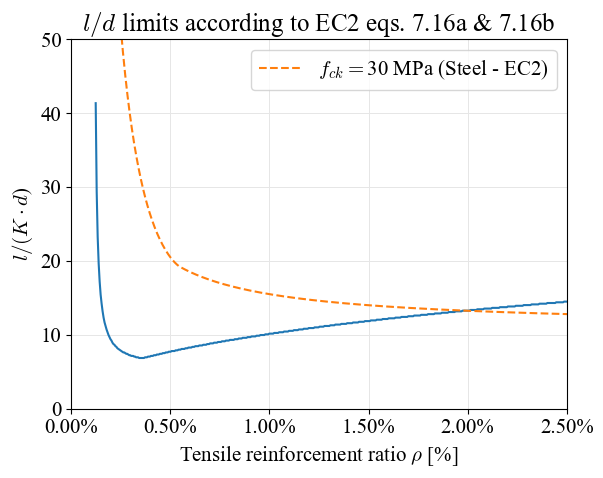

In [101]:
b_sls.plot_steel_sls_curves(ax, f_cks=[f_ck], axes_start_from_zero=True)
fig